In [1]:
import logging
import os
import cloudstorage as gcs

In [54]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/filipclaesson/Downloads/solar_fetch.json'

# Write to storage (used in Cloud Function)

In [14]:
import json
## File exists?
from google.cloud import storage
# create storage client
storage_client = storage.Client(project='custom-hold-263221')
# get bucket with name
bucket = storage_client.get_bucket('solar_storage')
# get bucket data as blob
file_name = '2020/09/03/data_test.txt'
blob = bucket.get_blob(file_name)
# if not storage.Blob(bucket=bucket, name=file_name).exists(storage_client):
#     print('no file')
#     new_file = bucket.blob(file_name)
#     new_file.upload_from_string(json.dumps(eval(a)))
# else:
#     print('done')

## Create a temporary table with the storage data

In [33]:
def if_tbl_exists(client, table_ref):
    from google.cloud.exceptions import NotFound
    try:
        client.get_table(table_ref)
        return True
    except NotFound:
        return False


from google.cloud import bigquery
client = bigquery.Client(project='custom-hold-263221')
table = bigquery.Table('custom-hold-263221.solar.solar_export')
external_config = bigquery.ExternalConfig("NEWLINE_DELIMITED_JSON")
external_config.source_uris = ["gs://solar_storage/solar_export/*"]
#external_config.autodetect = True

external_config.schema = [

    bigquery.SchemaField("published_at","TIMESTAMP"),
    bigquery.SchemaField("current_raw_avg","FLOAT"),
    bigquery.SchemaField("current_converted","FLOAT"),
    bigquery.SchemaField("current_raw_max","FLOAT"),
    bigquery.SchemaField("current_raw_median","FLOAT"),
    bigquery.SchemaField("device_id","STRING"),
    bigquery.SchemaField("event","STRING"),
    bigquery.SchemaField("current_raw_min","FLOAT"),
    bigquery.SchemaField("current_raw_std","FLOAT"),
    bigquery.SchemaField("voltage_converted","FLOAT"),
    bigquery.SchemaField("voltage_raw","FLOAT"),
    bigquery.SchemaField("current_raw","FLOAT"),
    ]
external_config.ignore_unknown_values=False
table.external_data_configuration = external_config

if if_tbl_exists(client, table):
    client.delete_table(table)
    
client.create_table(table,exists_ok=True)

Table(TableReference(DatasetReference('custom-hold-263221', 'solar'), 'solar_export'))

In [63]:
from google.cloud import bigquery

client = bigquery.Client(project='custom-hold-263221')
sql = """
    SELECT *

    FROM `custom-hold-263221.solar.solar_export`
"""

# Run a Standard SQL query using the environment's default project
df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = 'custom-hold-263221'
df = client.query(sql, project=project_id).to_dataframe()

In [64]:
df = df.set_index('published_at')

In [65]:
df.columns

Index(['current_raw_avg', 'current_converted', 'current_raw_max',
       'current_raw_median', 'device_id', 'event', 'current_raw_min',
       'current_raw_std', 'voltage_converted', 'voltage_raw', 'current_raw'],
      dtype='object')

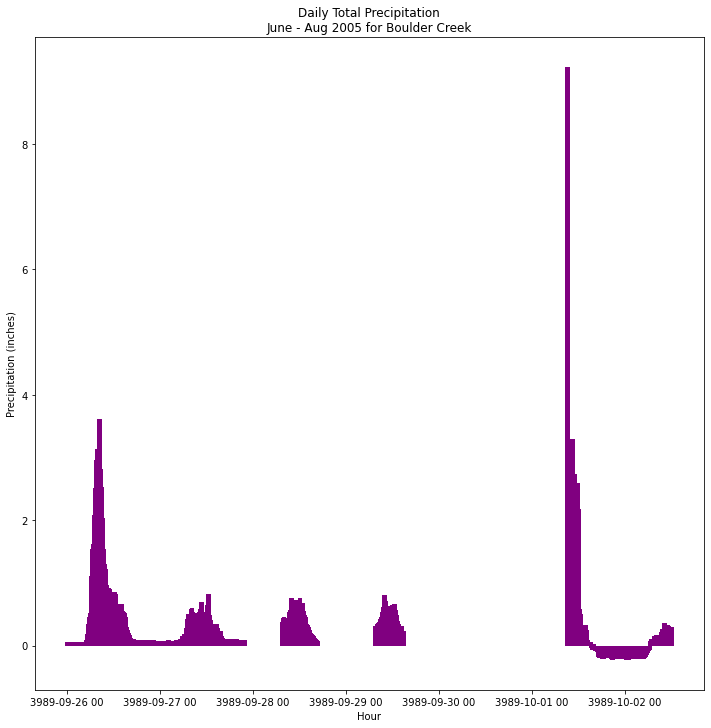

In [71]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
fig, ax = plt.subplots(figsize=(12, 12))


# Add x-axis and y-axis
ax.bar(df.loc['2020-09-25':'2020-10-01']['current_raw_avg'].index.values,
       (df.loc['2020-09-25':'2020-10-01']['current_raw_avg']-2950)*3.3*10/4095,
       color='purple',width=0.05)

# Set title and labels for axes
ax.set(xlabel="Hour",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek")

# Define the date format
date_form = DateFormatter("%Y-%m-%d %H")
ax.xaxis.set_major_formatter(date_form)

plt.show()

#df.loc['2020-09-23':'2020-09-24']['current_raw_median'].plot()
#date_form = DateFormatter("%m-%d")
#ax.xaxis.set_major_formatter(date_form)

In [67]:
df.loc['2020-09-23':'2020-09-25'].index

DatetimeIndex(['2020-09-23 11:23:22.425000+00:00',
               '2020-09-23 11:23:38.955000+00:00',
               '2020-09-23 11:25:07.270000+00:00',
               '2020-09-23 11:30:07.572000+00:00',
               '2020-09-23 11:31:21.606000+00:00',
               '2020-09-23 11:36:24.029000+00:00',
               '2020-09-23 11:41:26.546000+00:00',
               '2020-09-23 11:46:28.870000+00:00',
               '2020-09-23 11:51:31.298000+00:00',
               '2020-09-23 11:56:33.747000+00:00',
               ...
               '2020-09-24 23:13:44.110000+00:00',
               '2020-09-24 23:18:46.532000+00:00',
               '2020-09-24 23:23:48.861000+00:00',
               '2020-09-24 23:28:51.290000+00:00',
               '2020-09-24 23:33:53.702000+00:00',
               '2020-09-24 23:38:56.118000+00:00',
               '2020-09-24 23:43:58.557000+00:00',
               '2020-09-24 23:49:01.050000+00:00',
               '2020-09-24 23:54:03.467000+00:00',
            

In [68]:
df.loc['2020-09-25']['current_raw_avg'].min()

2954.6

In [69]:
### df['current_raw_to_volt'] = (df['current_raw']/4095)*3.3
df.loc['2020-09-21']['current_raw_to_volt'].plot()

KeyError: 'current_raw_to_volt'

In [204]:
df.loc['2020-09-22'][['current_converted','current_raw']].to_csv('hej.csv')

In [202]:
df.index

DatetimeIndex(['2020-09-22 05:40:28.374000+00:00',
               '2020-09-22 05:37:57.911000+00:00',
               '2020-09-22 05:35:27.481000+00:00',
               '2020-09-22 05:32:56.981000+00:00',
               '2020-09-22 05:30:26.521000+00:00',
               '2020-09-22 05:27:56.093000+00:00',
               '2020-09-22 05:25:25.681000+00:00',
               '2020-09-22 05:22:55.134000+00:00',
               '2020-09-22 05:20:24.665000+00:00',
               '2020-09-22 05:17:54.204000+00:00',
               ...
               '2020-09-04 20:12:14.323000+00:00',
               '2020-09-04 20:07:04.333000+00:00',
               '2020-09-04 20:01:54.352000+00:00',
               '2020-09-04 19:56:44.603000+00:00',
               '2020-09-04 19:51:34.333000+00:00',
               '2020-09-04 19:46:24.359000+00:00',
               '2020-09-04 19:41:14.416000+00:00',
               '2020-09-04 19:36:04.351000+00:00',
               '2020-09-04 19:30:54.361000+00:00',
            

In [197]:
df.sort_index(ascending=False).head(20)

,current_converted,current_raw
published_at,,
2020-09-21 16:45:37.372000+00:00,21.60,260.64
2020-09-21 16:40:37.336000+00:00,21.60,260.75
2020-09-21 16:35:37.238000+00:00,21.60,260.99
2020-09-21 16:30:37.225000+00:00,21.61,259.71
2020-09-21 16:25:37.224000+00:00,21.61,259.41
2020-09-21 16:20:37.289000+00:00,21.61,259.68
2020-09-21 16:15:37.188000+00:00,21.61,259.52
2020-09-21 16:10:37.172000+00:00,21.61,259.05
2020-09-21 16:05:37.212000+00:00,21.61,259.59


PeriodIndex(['2020-09-21 10:00', '2020-09-21 10:00', '2020-09-21 10:00',
             '2020-09-21 10:00', '2020-09-21 10:00', '2020-09-21 10:00',
             '2020-09-21 10:00', '2020-09-21 09:00', '2020-09-21 09:00',
             '2020-09-21 09:00',
             ...
             '2020-09-04 20:00', '2020-09-04 20:00', '2020-09-04 20:00',
             '2020-09-04 19:00', '2020-09-04 19:00', '2020-09-04 19:00',
             '2020-09-04 19:00', '2020-09-04 19:00', '2020-09-04 19:00',
             '2020-09-04 19:00'],
            dtype='period[H]', name='published_at', length=3704, freq='H')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


<AxesSubplot:xlabel='published_at'>

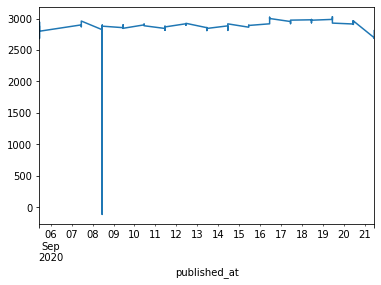

In [191]:
plot_df = df.copy()
plot_df.index = plot_df.index.to_period('H')
plot_df[(plot_df.index.hour==11) & (plot_df.index > '2020-09-01')]['current_raw'].plot()

In [184]:
plot_df[(plot_df.index.hour==7)]['current_converted'].max()

3.75